# Spatial Patterns of Extremes

## Imports

In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 

## Stop session if needed

In [ ]:
#spark.stop()

## Start Spark session

In [2]:
spark = SparkSession.builder.master('local[*]').appName('Climalyticsat').config('spark.driver.memory', '8g').config('spark.executor.memory', '8g').getOrCreate()

25/05/18 18:03:45 WARN Utils: Your hostname, arch-df23 resolves to a loopback address: 127.0.1.1; using 10.0.0.63 instead (on interface wlp2s0)
25/05/18 18:03:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/18 18:03:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/18 18:03:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Load data and write out as Parquet

### Load all station's climate data

In [3]:
climate_data = spark.read.csv('climate_all_stations.csv', header=True, inferSchema=True)

### Extract a “year” column for efficient time‐based pruning

In [4]:
# turn string into a proper date, then pull out the year
climate_data = (
    climate_data
      .withColumn('date',   to_date('date', 'yyyy-MM'))
      .withColumn('year',   year('date'))
)

### Load and join stations metadata

In [5]:
stations = (
    spark.read
         .csv('stations_metadata.csv', header=True, inferSchema=True)
         .withColumnRenamed('id', 'station_id')
         .withColumnRenamed('Höhe [m]', 'elevation')
         .select('station_id', 'elevation')
)

climate = climate_data.join(stations, on='station_id', how='inner')

#### Bucket elevation into (250m) bands

In [6]:
climate = climate.withColumn(
    'elevation_band',
    (floor(climate.elevation / 250) * 250).cast('int')  # 0–249m → 0, 250–499m → 250, etc.
)

### Write out as Parquet, partitioned by year & elevation_band

In [8]:
climate.write.partitionBy('year', 'elevation_band').parquet('extremes_parquet/')

## RQ2 - Spatial Patterns of Extremes
Which geographic zones (valleys, plateaus, alpine corridors) show the largest shifts in “hot days” (≥ 30 °C) and “frost days” (≤ 0 °C) since 1970?

### Load Parquet (qear, elevation_band)

In [3]:
climate = spark.read.parquet('extremes_parquet/')

25/05/18 18:03:59 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


### Add geogrpahic zones

In [4]:
# needed columns
# tage_tropen,Tropentage,"Zahl der Tropentage,  Tagesmaximum der Lufttemperatur in 2 m Höhe >=30.0°C",d
# tage_frost,Frosttage,"Zahl der Frosttage, 24-Stunden-Minimalwert der Lufttemperatur in 2m Höhe < 0.0 °C",d

climate = climate.withColumn(
    'zone',
    when(col('elevation') <= 900,      'valley')
   .when((col('elevation') > 900) & (col('elevation') <= 1900), 'plateau')
   .otherwise('alpine')
)

### Compute the “shift” since 1970

#### End-minus-start difference

In [16]:
# 1) total per station×year
zone_year_station = (
    climate
      .groupBy('zone','station_id','year')
      .agg(
        _sum('tage_tropen').alias('hot_days'),
        _sum('tage_frost').alias('frost_days')
      )
)

# 2) average per zone×year
zone_year = (
    zone_year_station
      .groupBy('zone','year')
      .agg(
        avg('hot_days' ).alias('hot_days'),
        avg('frost_days').alias('frost_days')
      )
)

In [17]:
first_decade = (zone_year
    .filter(col('year').between(1970,1979))
    .groupBy('zone')
    .agg(avg('hot_days').alias('hot_70s'),
         avg('frost_days').alias('frost_70s'))
)

last_decade = (zone_year
    .filter(col('year').between(2015,2024))
    .groupBy('zone')
    .agg(avg('hot_days').alias('hot_10s'),
         avg('frost_days').alias('frost_10s'))
)

shift = (first_decade
    .join(last_decade, 'zone')
    .withColumn('hot_shift',   col('hot_10s')   - col('hot_70s'))
    .withColumn('frost_shift', col('frost_10s') - col('frost_70s'))
)


In [18]:
# print the per-zone, per-decade averages
first_decade.show(truncate=False)
last_decade.show(truncate=False)

# print the computed shifts
shift.select('zone','hot_70s','hot_10s','hot_shift',
             'frost_70s','frost_10s','frost_shift') \
     .show(truncate=False)


+-------+------------------+------------------+
|zone   |hot_70s           |frost_70s         |
+-------+------------------+------------------+
|valley |4.451866128141181 |113.27430371447363|
|alpine |0.0               |206.5379917317804 |
|plateau|0.2779790773992113|153.37116894618572|
+-------+------------------+------------------+



+-------+------------------+------------------+
|zone   |hot_10s           |frost_10s         |
+-------+------------------+------------------+
|valley |20.161767036138304|90.94557690649654 |
|alpine |0.0               |210.9476900584795 |
|plateau|2.5462382999883   |132.24981089856092|
+-------+------------------+------------------+



+-------+------------------+------------------+------------------+------------------+------------------+-------------------+
|zone   |hot_70s           |hot_10s           |hot_shift         |frost_70s         |frost_10s         |frost_shift        |
+-------+------------------+------------------+------------------+------------------+------------------+-------------------+
|valley |4.451866128141181 |20.161767036138304|15.709900907997124|113.27430371447363|90.94557690649654 |-22.32872680797709 |
|alpine |0.0               |0.0               |0.0               |206.5379917317804 |210.9476900584795 |4.4096983266991    |
|plateau|0.2779790773992113|2.5462382999883   |2.268259222589089 |153.37116894618572|132.24981089856092|-21.121358047624796|
+-------+------------------+------------------+------------------+------------------+------------------+-------------------+



### Visualize with matplotlib

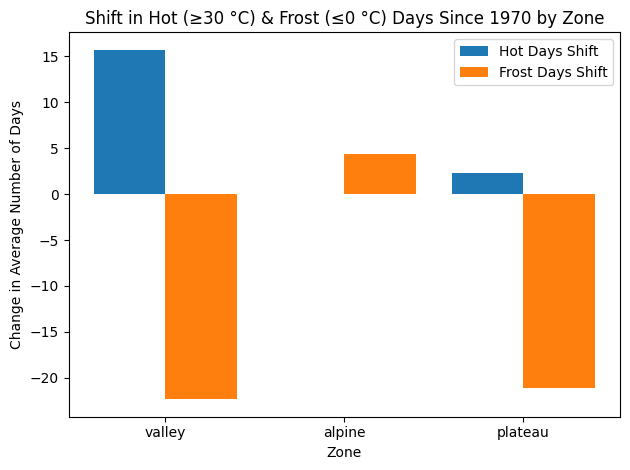

In [19]:
import matplotlib.pyplot as plt

shift_pd = shift.toPandas()

zones      = shift_pd['zone']
hot_shift  = shift_pd['hot_shift']
frost_shift= shift_pd['frost_shift']
x = range(len(zones))

plt.figure()
plt.bar([i - 0.2 for i in x], hot_shift,   width=0.4, label='Hot Days Shift')
plt.bar([i + 0.2 for i in x], frost_shift, width=0.4, label='Frost Days Shift')
plt.xticks(x, zones)
plt.xlabel('Zone')
plt.ylabel('Change in Average Number of Days')
plt.title('Shift in Hot (≥30 °C) & Frost (≤0 °C) Days Since 1970 by Zone')
plt.legend()
plt.tight_layout()
plt.show()


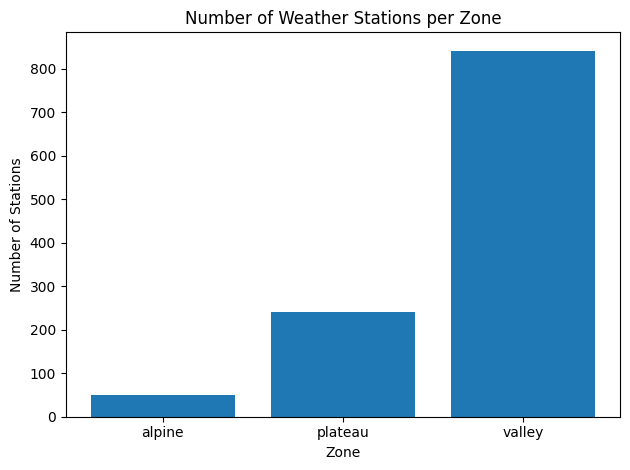

In [23]:
station_counts = (
    climate
      .select('station_id', 'zone')
      .distinct()
      .groupBy('zone')
      .agg(countDistinct('station_id').alias('num_stations'))
      .orderBy('zone')
)

# 3) Bring to Pandas & plot
station_counts_pd = station_counts.toPandas()

import matplotlib.pyplot as plt

zones  = station_counts_pd['zone']
counts = station_counts_pd['num_stations']
x      = range(len(zones))

plt.figure()
plt.bar(x, counts)
plt.xticks(x, zones)
plt.xlabel('Zone')
plt.ylabel('Number of Stations')
plt.title('Number of Weather Stations per Zone')
plt.tight_layout()
plt.show()